Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::f

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

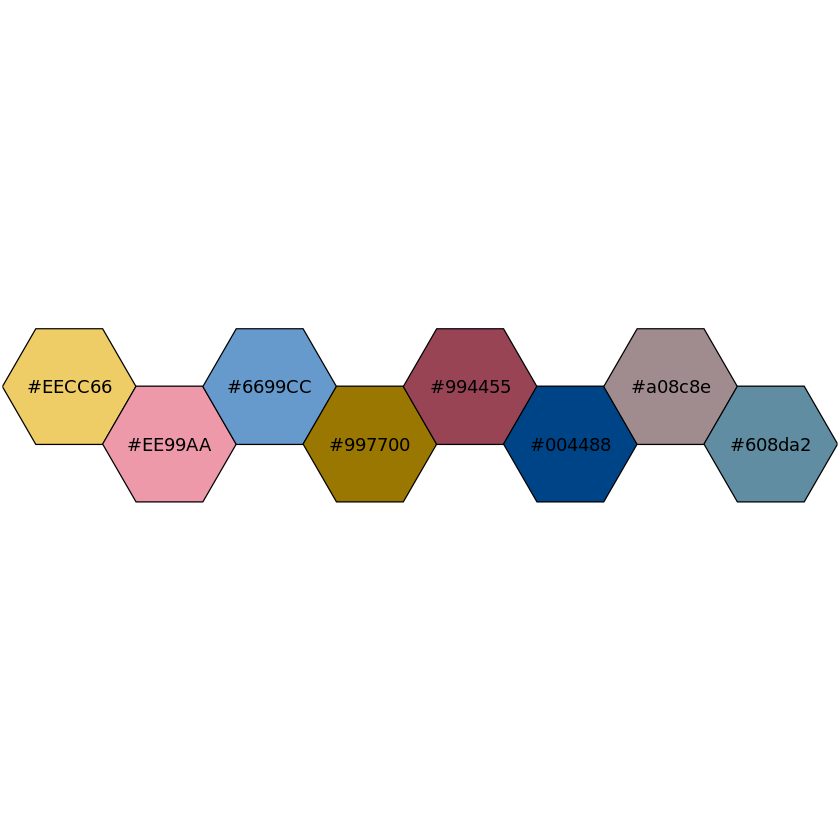

In [1]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [2]:
readBAM <- function(bamFile){
  bam <- scanBam(bamFile)
  .unlist <- function (x){
    x1 <- x[[1L]]
    if (is.factor(x1)){
      structure(unlist(x), class = "factor", levels = levels(x1))
    } else {
      do.call(c, x)
    }
  }
  bam_field <- names(bam[[1]])
  list <- lapply(bam_field, function(y) .unlist(lapply(bam, "[[", y)))
  bam_df <- do.call("DataFrame", list)
  names(bam_df) <- bam_field
  return(bam_df)
}

In [3]:
Asp_fum_fna <- read.fasta("/hpc/compgen/projects/cf-spi/cf-spi/analysis/ewesdorp/github_cfspi/cfspi/resources/mapping/fungal/EPRSc2_746128.fna")
Asp_fum_fna_stats <- lengths(Asp_fum_fna) %>% as.data.frame()
colnames(Asp_fum_fna_stats) <- "length"

In [4]:
if (exists("all_Afum")){rm("all_Afum")}
for (f in list.files(SPL_Asp_map, pattern = "[l/p]_EPRSc2_conf0.4_746128_AfumigatusAf293_srt.bam$")){
    bam_tmp <- readBAM(paste0(SPL_Asp_map, f)) %>% as.data.frame() %>% 
        mutate(sample_id = unlist(strsplit(f, split = "_"))[1])
    if (!exists("all_Afum")){all_Afum <- bam_tmp} else {all_Afum <- rbind(all_Afum, bam_tmp)}
}

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `origin = fct_relevel(...)`.
Caused by warning:
! 1 unknown level in `f`: controls”
Using sample_id, origin, sample as id variables

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


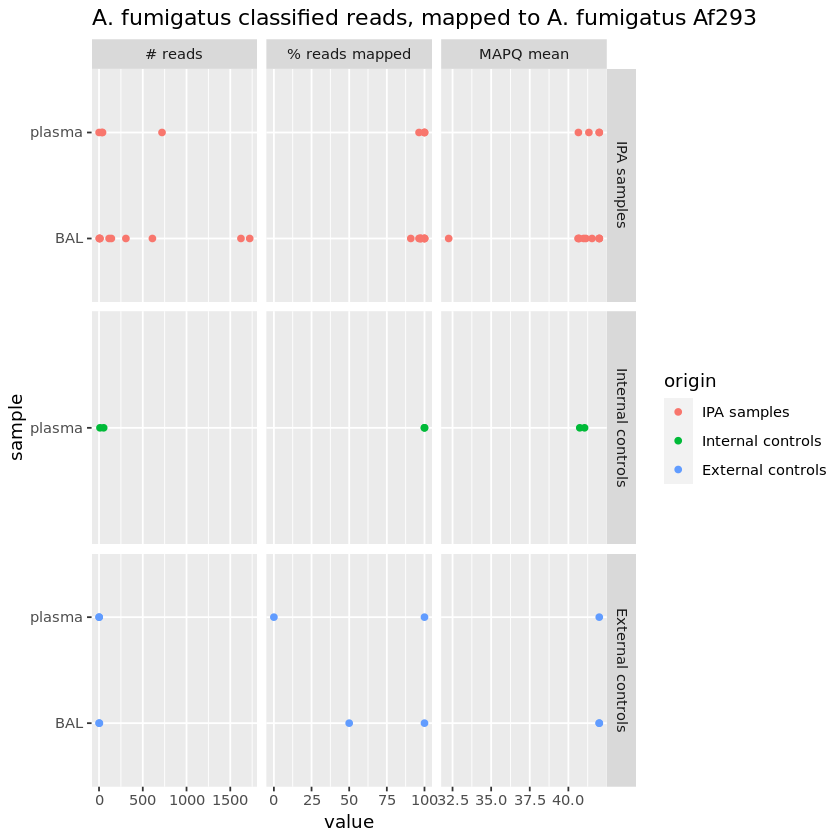

In [5]:
all_Afum %>% 
    group_by(sample_id) %>% 
    summarise(n = n()/2, 
              n_mapped = sum(!is.na(rname))/2, 
              prct_mapped = n_mapped/n*100, 
              mean_mapq = mean(mapq, na.rm = TRUE))  %>% 
    mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                    ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                    ifelse(grepl(sample_id, pattern = "^H"), yes = "External controls", 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA))))) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                  ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control"))) %>% 
    mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","External controls", "controls"))) %>% 
    select(-n_mapped) %>% melt() %>% 
    mutate(variable = ifelse(variable == "n", yes = "# reads", no = 
            ifelse(variable == "prct_mapped", yes = "% reads mapped", no = 
            ifelse(variable == "mean_mapq", yes = "MAPQ mean", no = NA)))) %>% 
    ggplot(aes(x = value, y = sample, col = origin, fill = origin)) + 
        geom_point() + 
        facet_grid(cols = vars(variable), rows = vars(origin), scales = "free") + 
        ggtitle(label = "A. fumigatus classified reads, mapped to A. fumigatus Af293")

In [6]:
if (exists("BAM_BAL_Afum")){rm("BAM_BAL_Afum")}
plot_bam = list()
plot_Basp = list()
for (cntg in rownames(Asp_fum_fna_stats)){
    for (pt in c("A01Basp","A02Basp","A04Basp","A14Basp","A15Basp")){
        bam_tmp <- readBAM(paste0(SPL_Asp_map, pt, "_EPRSc2_conf0.4_746128_AfumigatusAf293_srt.bam")) %>% as.data.frame()
    
        bin = Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,]/150
        plot_bam[[pt]] <- bam_tmp %>% 
            filter(strand == "+") %>% 
            mutate(end_pos = pos + bin) %>% 
            mutate(start_pos = pos - bin) %>% 
            filter(rname == cntg)  %>%
            mutate(yrandom = sample(1:nrow(.), size = nrow(.), replace = F)) %>% 
            ggplot(aes(x=pos)) + 
                geom_histogram(aes(y=..density..), bins = 30, fill = "grey", col = "grey") +
                geom_density(alpha=.3, col = colors_mc[4]) +
                #geom_segment(aes(x = start_pos, xend = end_pos, y = yrandom, yend = yrandom)) + 
                xlim(c(0-bin), c(as.numeric(Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,])+bin)) + theme_classic() + 
                ylab("density") + xlab("") + ggtitle(label = "", subtitle = gsub(cntg, pattern = "_.*", replacement = "")) + 
                theme(axis.text= element_blank(), axis.ticks= element_blank(),
                      plot.title = element_text(hjust = 0.5)) + 
                geom_text(data = . %>% summarise(n = paste0(" n=", n())), aes(x=-Inf, y=Inf, label=n), 
                    colour="black", size = 4, hjust = 0, vjust = 1)
        if(cntg == rownames(Asp_fum_fna_stats)[1]){
            plot_bam[[pt]] <- plot_bam[[pt]] + ggtitle(label = gsub(pt, pattern = "Basp", replacement = " - BAL"))}
        
        if (!exists("BAM_BAL_Afum")){BAM_BAL_Afum <- bam_tmp} else {BAM_BAL_Afum <- rbind(BAM_BAL_Afum, bam_tmp)}
    }
    plot_Basp[[cntg]] <- plot_bam
}
plot_Basp_dens = list()
for (cntg in rownames(Asp_fum_fna_stats)){
    bin=Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,]/150
    plot_Basp_dens[[cntg]] <- BAM_BAL_Afum %>% 
        filter(strand == "+") %>% 
        filter(rname == cntg)  %>%
        ggplot(aes(x=pos)) + geom_density(alpha=.3, col = colors_mc[4]) + theme_classic() + 
            xlim(c(0-bin), c(as.numeric(Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,])+bin)) + 
            ylab("density") + xlab("") + ggtitle(label = "Combined", subtitle = gsub(cntg, pattern = "_.*", replacement = "")) +
            theme(axis.text.y= element_blank(), axis.ticks.y= element_blank(),
                  plot.title = element_text(hjust = 0.5)) + scale_x_continuous(labels = function(x) sprintf("%g", x))
}                                                                                                                                                    

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


In [7]:
if (exists("BAM_BAL_Afum")){rm("BAM_BAL_Afum")}
plot_bam = list()
plot_Pasp = list()
for (cntg in rownames(Asp_fum_fna_stats)){
    for (pt in c("A01Pasp","A02Pasp","A03Pasp")){
        bam_tmp <- readBAM(paste0(SPL_Asp_map, pt, "_EPRSc2_conf0.4_746128_AfumigatusAf293_srt.bam")) %>% as.data.frame()
    
        bin= Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,]/150
        plot_bam[[pt]] <- bam_tmp %>% 
            filter(strand == "+") %>% 
            mutate(end_pos = pos + bin) %>% 
            mutate(start_pos = pos - bin) %>% 
            filter(rname == cntg)  %>%
            mutate(yrandom = sample(1:nrow(.), size = nrow(.), replace = F)) %>% 
            ggplot(aes(x=pos)) + 
                geom_histogram(aes(y=..density..), bins = 30, fill = "grey", col = "grey") +
                geom_density(alpha=.3, col = colors_mc[5]) +
                #geom_segment(aes(x = start_pos, xend = end_pos, y = yrandom, yend = yrandom)) + 
                xlim(c(0-bin), c(as.numeric(Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,])+bin)) + theme_classic() + 
                ylab("density") + xlab("") + ggtitle(label = "", subtitle = gsub(cntg, pattern = "_.*", replacement = "")) + 
                theme(axis.text= element_blank(), axis.ticks= element_blank(),
                      plot.title = element_text(hjust = 0.5)) + 
                geom_text(data = . %>% summarise(n = paste0(" n=", n())), aes(x=-Inf, y=Inf, label=n), 
                    colour="black", size = 4, hjust = 0, vjust = 1)
        if(cntg == rownames(Asp_fum_fna_stats)[1]){
            plot_bam[[pt]] <- plot_bam[[pt]] + ggtitle(label = gsub(pt, pattern = "Pasp", replacement = " - plasma"))}
        
        if (!exists("BAM_plasma_Afum")){BAM_BAL_Afum <- bam_tmp} else {BAM_BAL_Afum <- rbind(BAM_BAL_Afum, bam_tmp)}
    }
    plot_Pasp[[cntg]] <- plot_bam
}
plot_Pasp_dens = list()
for (cntg in rownames(Asp_fum_fna_stats)){
    bin=Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,]/150
    plot_Pasp_dens[[cntg]] <- BAM_BAL_Afum %>% 
        filter(strand == "+") %>% 
        filter(rname == cntg)  %>%
        ggplot(aes(x=pos)) + geom_density(alpha=.3, col = colors_mc[5]) + theme_classic() + 
            xlim(c(0-bin), c(as.numeric(Asp_fum_fna_stats[rownames(Asp_fum_fna_stats) == cntg,])+bin)) + 
            ylab("density") + xlab("") + ggtitle(label = "Combined", subtitle = gsub(cntg, pattern = "_.*", replacement = "")) +
            theme(axis.text.y= element_blank(), axis.ticks.y= element_blank(),
                  plot.title = element_text(hjust = 0.5)) + scale_x_continuous(labels = function(x) sprintf("%g", x))
}                                                                                                                   

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 row

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning mess

Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning mess

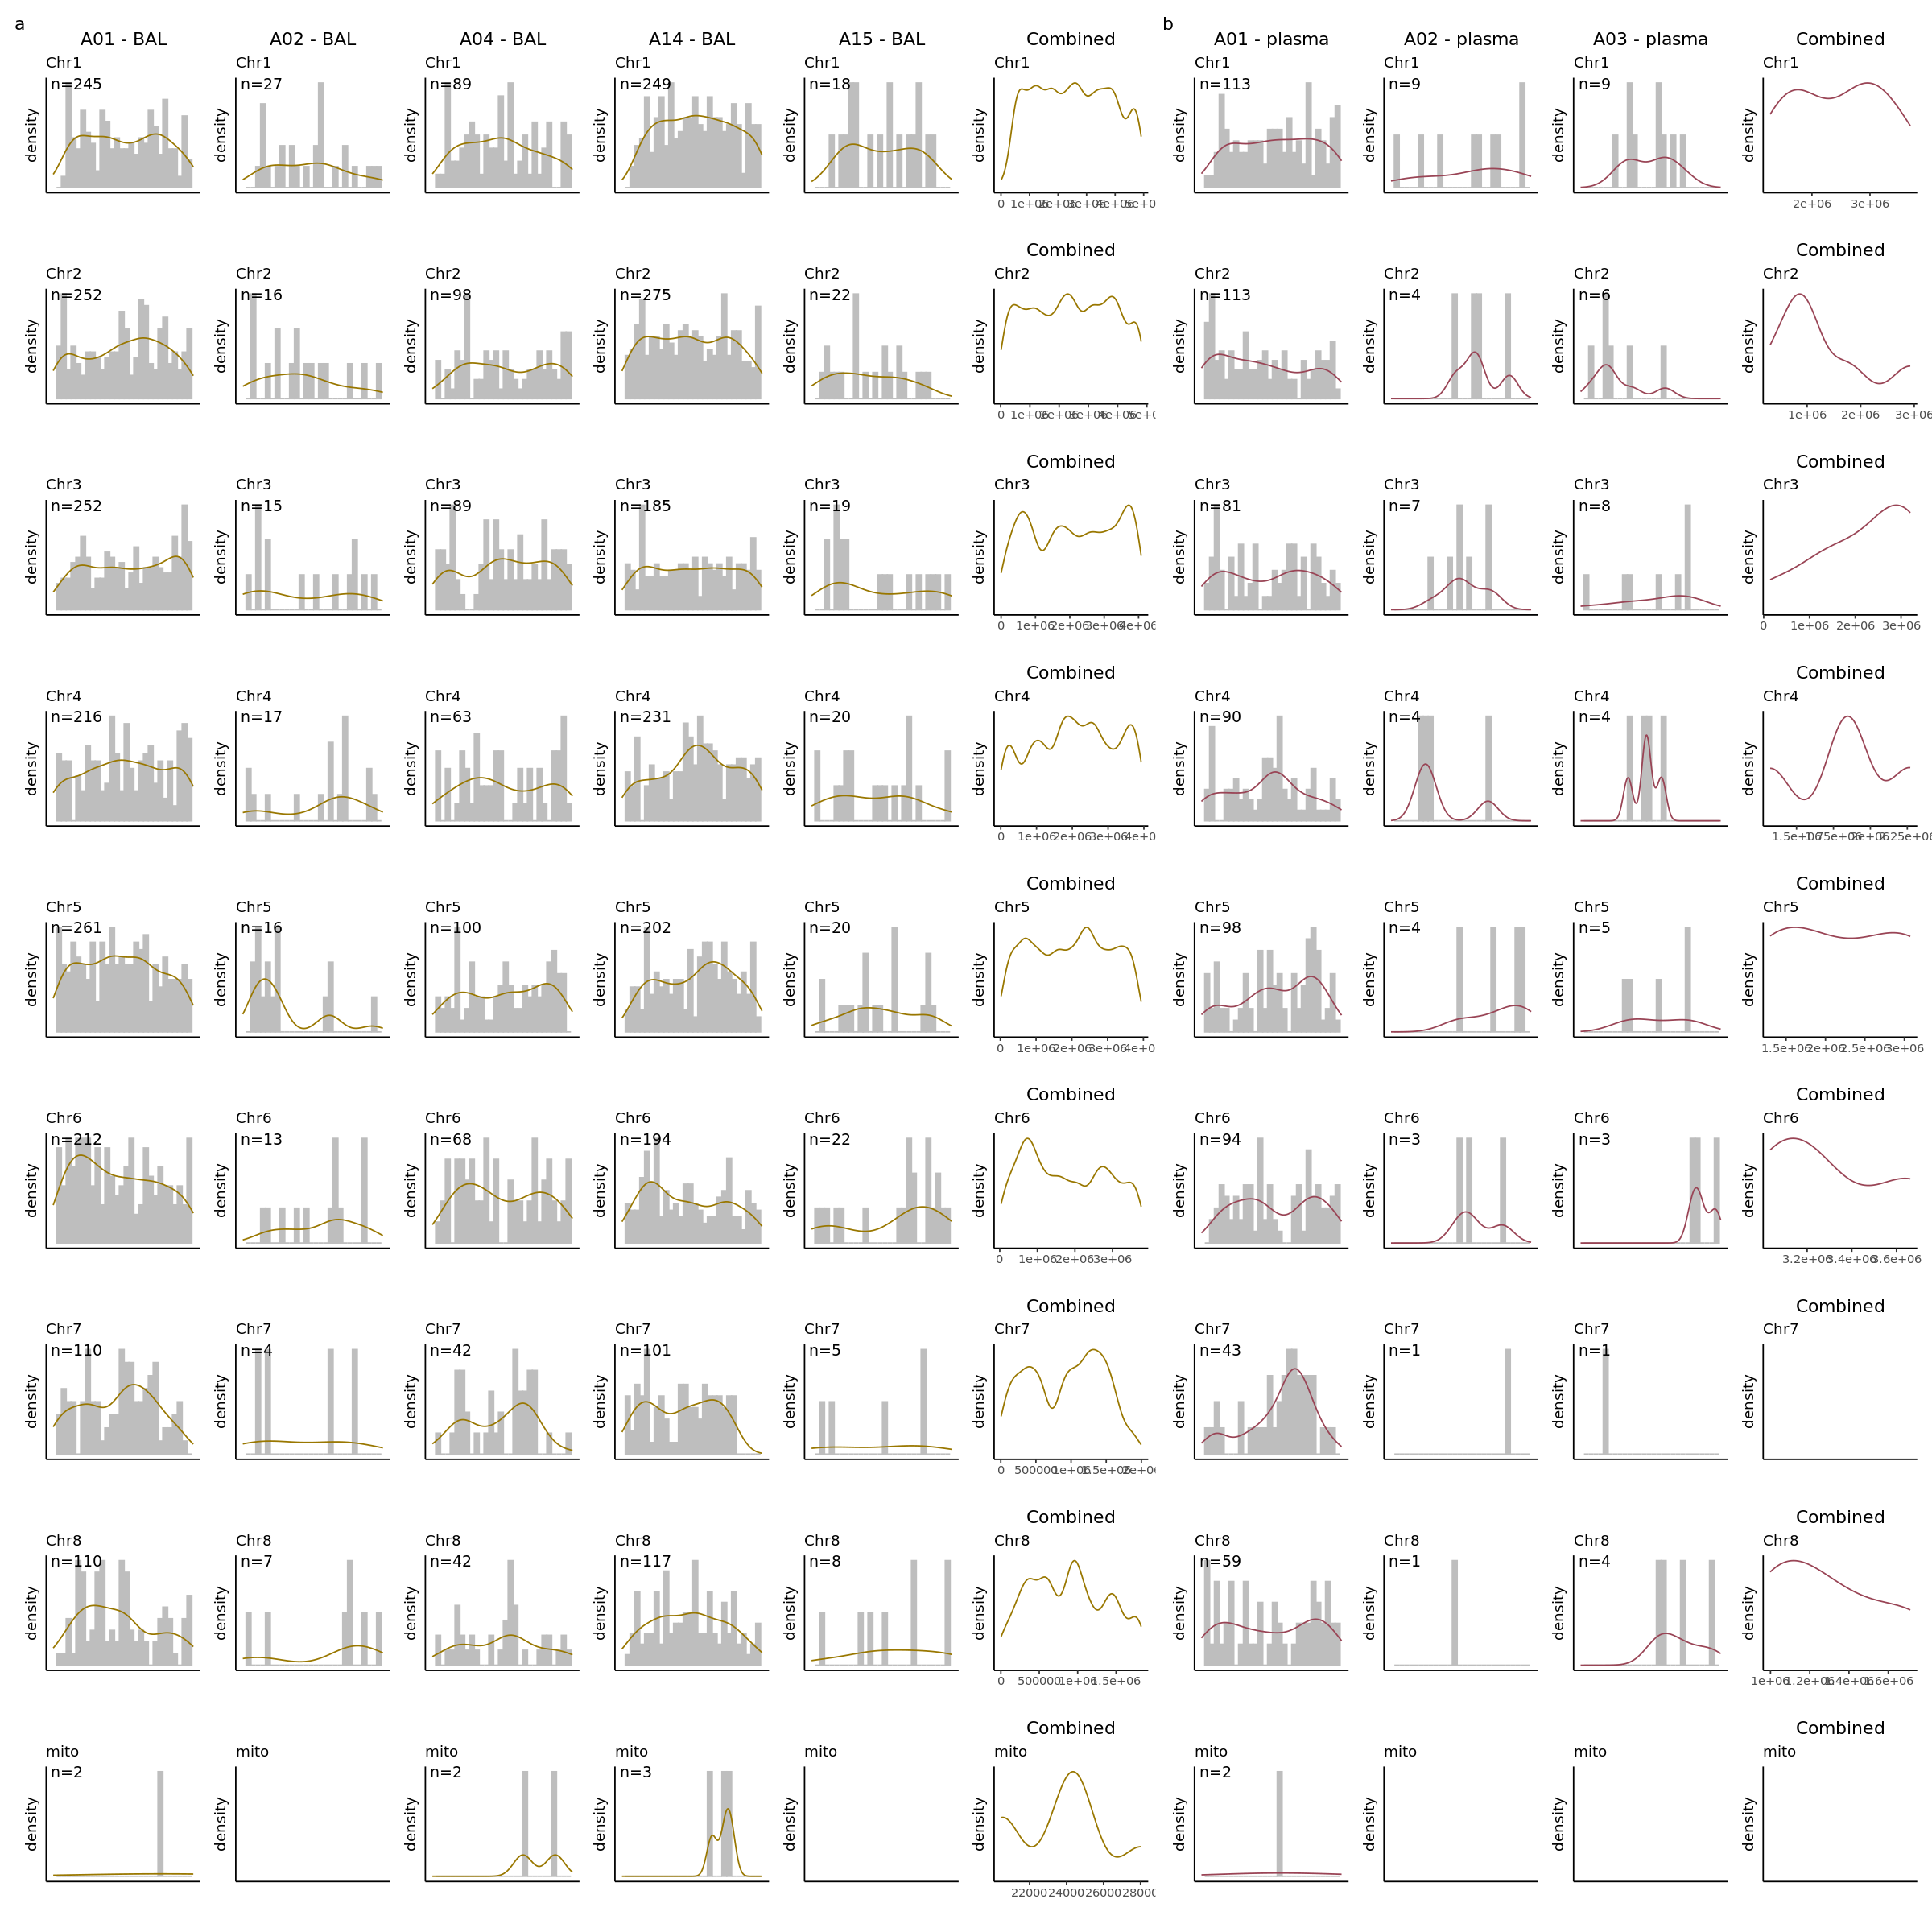

In [8]:
options(repr.plot.width=20, repr.plot.height=20)
SuplFig15 <- 
    (plot_Basp[[1]][[1]] + labs(tag = "a")) + plot_Basp[[1]][[2]] + plot_Basp[[1]][[3]] + plot_Basp[[1]][[4]] + plot_Basp[[1]][[5]] + plot_Basp_dens[[1]] + 
    (plot_Pasp[[1]][[1]] + labs(tag = "b")) + plot_Pasp[[1]][[2]] + plot_Pasp[[1]][[3]] + plot_Pasp_dens[[1]] + 
    plot_Basp[[2]][[1]] + plot_Basp[[2]][[2]] + plot_Basp[[2]][[3]] + plot_Basp[[2]][[4]] + plot_Basp[[2]][[5]] + plot_Basp_dens[[2]] +
    plot_Pasp[[2]][[1]] + plot_Pasp[[2]][[2]] + plot_Pasp[[2]][[3]] + plot_Pasp_dens[[2]] +
    plot_Basp[[3]][[1]] + plot_Basp[[3]][[2]] + plot_Basp[[3]][[3]] + plot_Basp[[3]][[4]] + plot_Basp[[3]][[5]] + plot_Basp_dens[[3]] +
    plot_Pasp[[3]][[1]] + plot_Pasp[[3]][[2]] + plot_Pasp[[3]][[3]] + plot_Pasp_dens[[3]] +
    plot_Basp[[4]][[1]] + plot_Basp[[4]][[2]] + plot_Basp[[4]][[3]] + plot_Basp[[4]][[4]] + plot_Basp[[4]][[5]] + plot_Basp_dens[[4]] +
    plot_Pasp[[4]][[1]] + plot_Pasp[[4]][[2]] + plot_Pasp[[4]][[3]] + plot_Pasp_dens[[4]] +
    plot_Basp[[5]][[1]] + plot_Basp[[5]][[2]] + plot_Basp[[5]][[3]] + plot_Basp[[5]][[4]] + plot_Basp[[5]][[5]] + plot_Basp_dens[[5]] +
    plot_Pasp[[5]][[1]] + plot_Pasp[[5]][[2]] + plot_Pasp[[5]][[3]] + plot_Pasp_dens[[5]] +
    plot_Basp[[6]][[1]] + plot_Basp[[6]][[2]] + plot_Basp[[6]][[3]] + plot_Basp[[6]][[4]] + plot_Basp[[6]][[5]] + plot_Basp_dens[[6]] +
    plot_Pasp[[6]][[1]] + plot_Pasp[[6]][[2]] + plot_Pasp[[6]][[3]] + plot_Pasp_dens[[6]] +
    plot_Basp[[7]][[1]] + plot_Basp[[7]][[2]] + plot_Basp[[7]][[3]] + plot_Basp[[7]][[4]] + plot_Basp[[7]][[5]] + plot_Basp_dens[[7]] +
    plot_Pasp[[7]][[1]] + plot_Pasp[[7]][[2]] + plot_Pasp[[7]][[3]] + plot_Pasp_dens[[7]] +
    plot_Basp[[8]][[1]] + plot_Basp[[8]][[2]] + plot_Basp[[8]][[3]] + plot_Basp[[8]][[4]] + plot_Basp[[8]][[5]] + plot_Basp_dens[[8]] +
    plot_Pasp[[8]][[1]] + plot_Pasp[[8]][[2]] + plot_Pasp[[8]][[3]] + plot_Pasp_dens[[8]] +
    plot_Basp[[9]][[1]] + plot_Basp[[9]][[2]] + plot_Basp[[9]][[3]] + plot_Basp[[9]][[4]] + plot_Basp[[9]][[5]] + plot_Basp_dens[[9]] +
    plot_Pasp[[9]][[1]] + plot_Pasp[[9]][[2]] + plot_Pasp[[9]][[3]] + plot_Pasp_dens[[9]] +
    plot_layout(ncol = 10) + theme(plot.tag = element_text(face = 'bold', size = 20))

SuplFig15

ggsave("../../output/suppl_figures/SuplFig15_R.png", 
       SuplFig15, width = 20, height = 20)
ggsave("../../output/suppl_figures/SuplFig15_R.pdf", 
       SuplFig15, width = 20, height = 20)

In [9]:
if (exists("bam_all_Asp")){rm("bam_all_Asp")}
bam_all_Asp = list()
for (f in list.files(path = SPL_Asp_map, pattern = "_srt.bam$")){
    file_splt <- unlist(str_split(f, "_"))
    
    bam_tmp <- readBAM(paste0(SPL_Asp_map,f)) %>% as.data.frame()
    bam_tmp2 <- bam_tmp %>% 
        mutate(sample = file_splt[1], 
               db = file_splt[2], 
               CT = file_splt[3], 
               remap_genome = file_splt[4], 
               tax_name = file_splt[5]) %>% 
        mutate(tax_name = sub(tax_name, pattern = "^A", replacement = "Aspergillus "))
    
    if (!exists("bam_all_Asp")){bam_all_Asp <- bam_tmp2} else {bam_all_Asp <- rbind(bam_all_Asp, bam_tmp2)}
}

db,CT,remap_genome,tax_name,median
<chr>,<chr>,<chr>,<chr>,<dbl>
EPRSc2,conf0.4,746128,Aspergillus fischeri NRRL181,54.0
EPRSc2,conf0.4,746128,Aspergillus fumigatus A1163,97.9
EPRSc2,conf0.4,746128,Aspergillus fumigatus Af293,97.6
EPRSc2,conf0.4,746128,Aspergillus novofumigatus IBT16806,36.2


Warning message:
“Removed 121 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 121 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 121 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 121 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 121 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 121 rows containing missing values (`geom_point()`).”


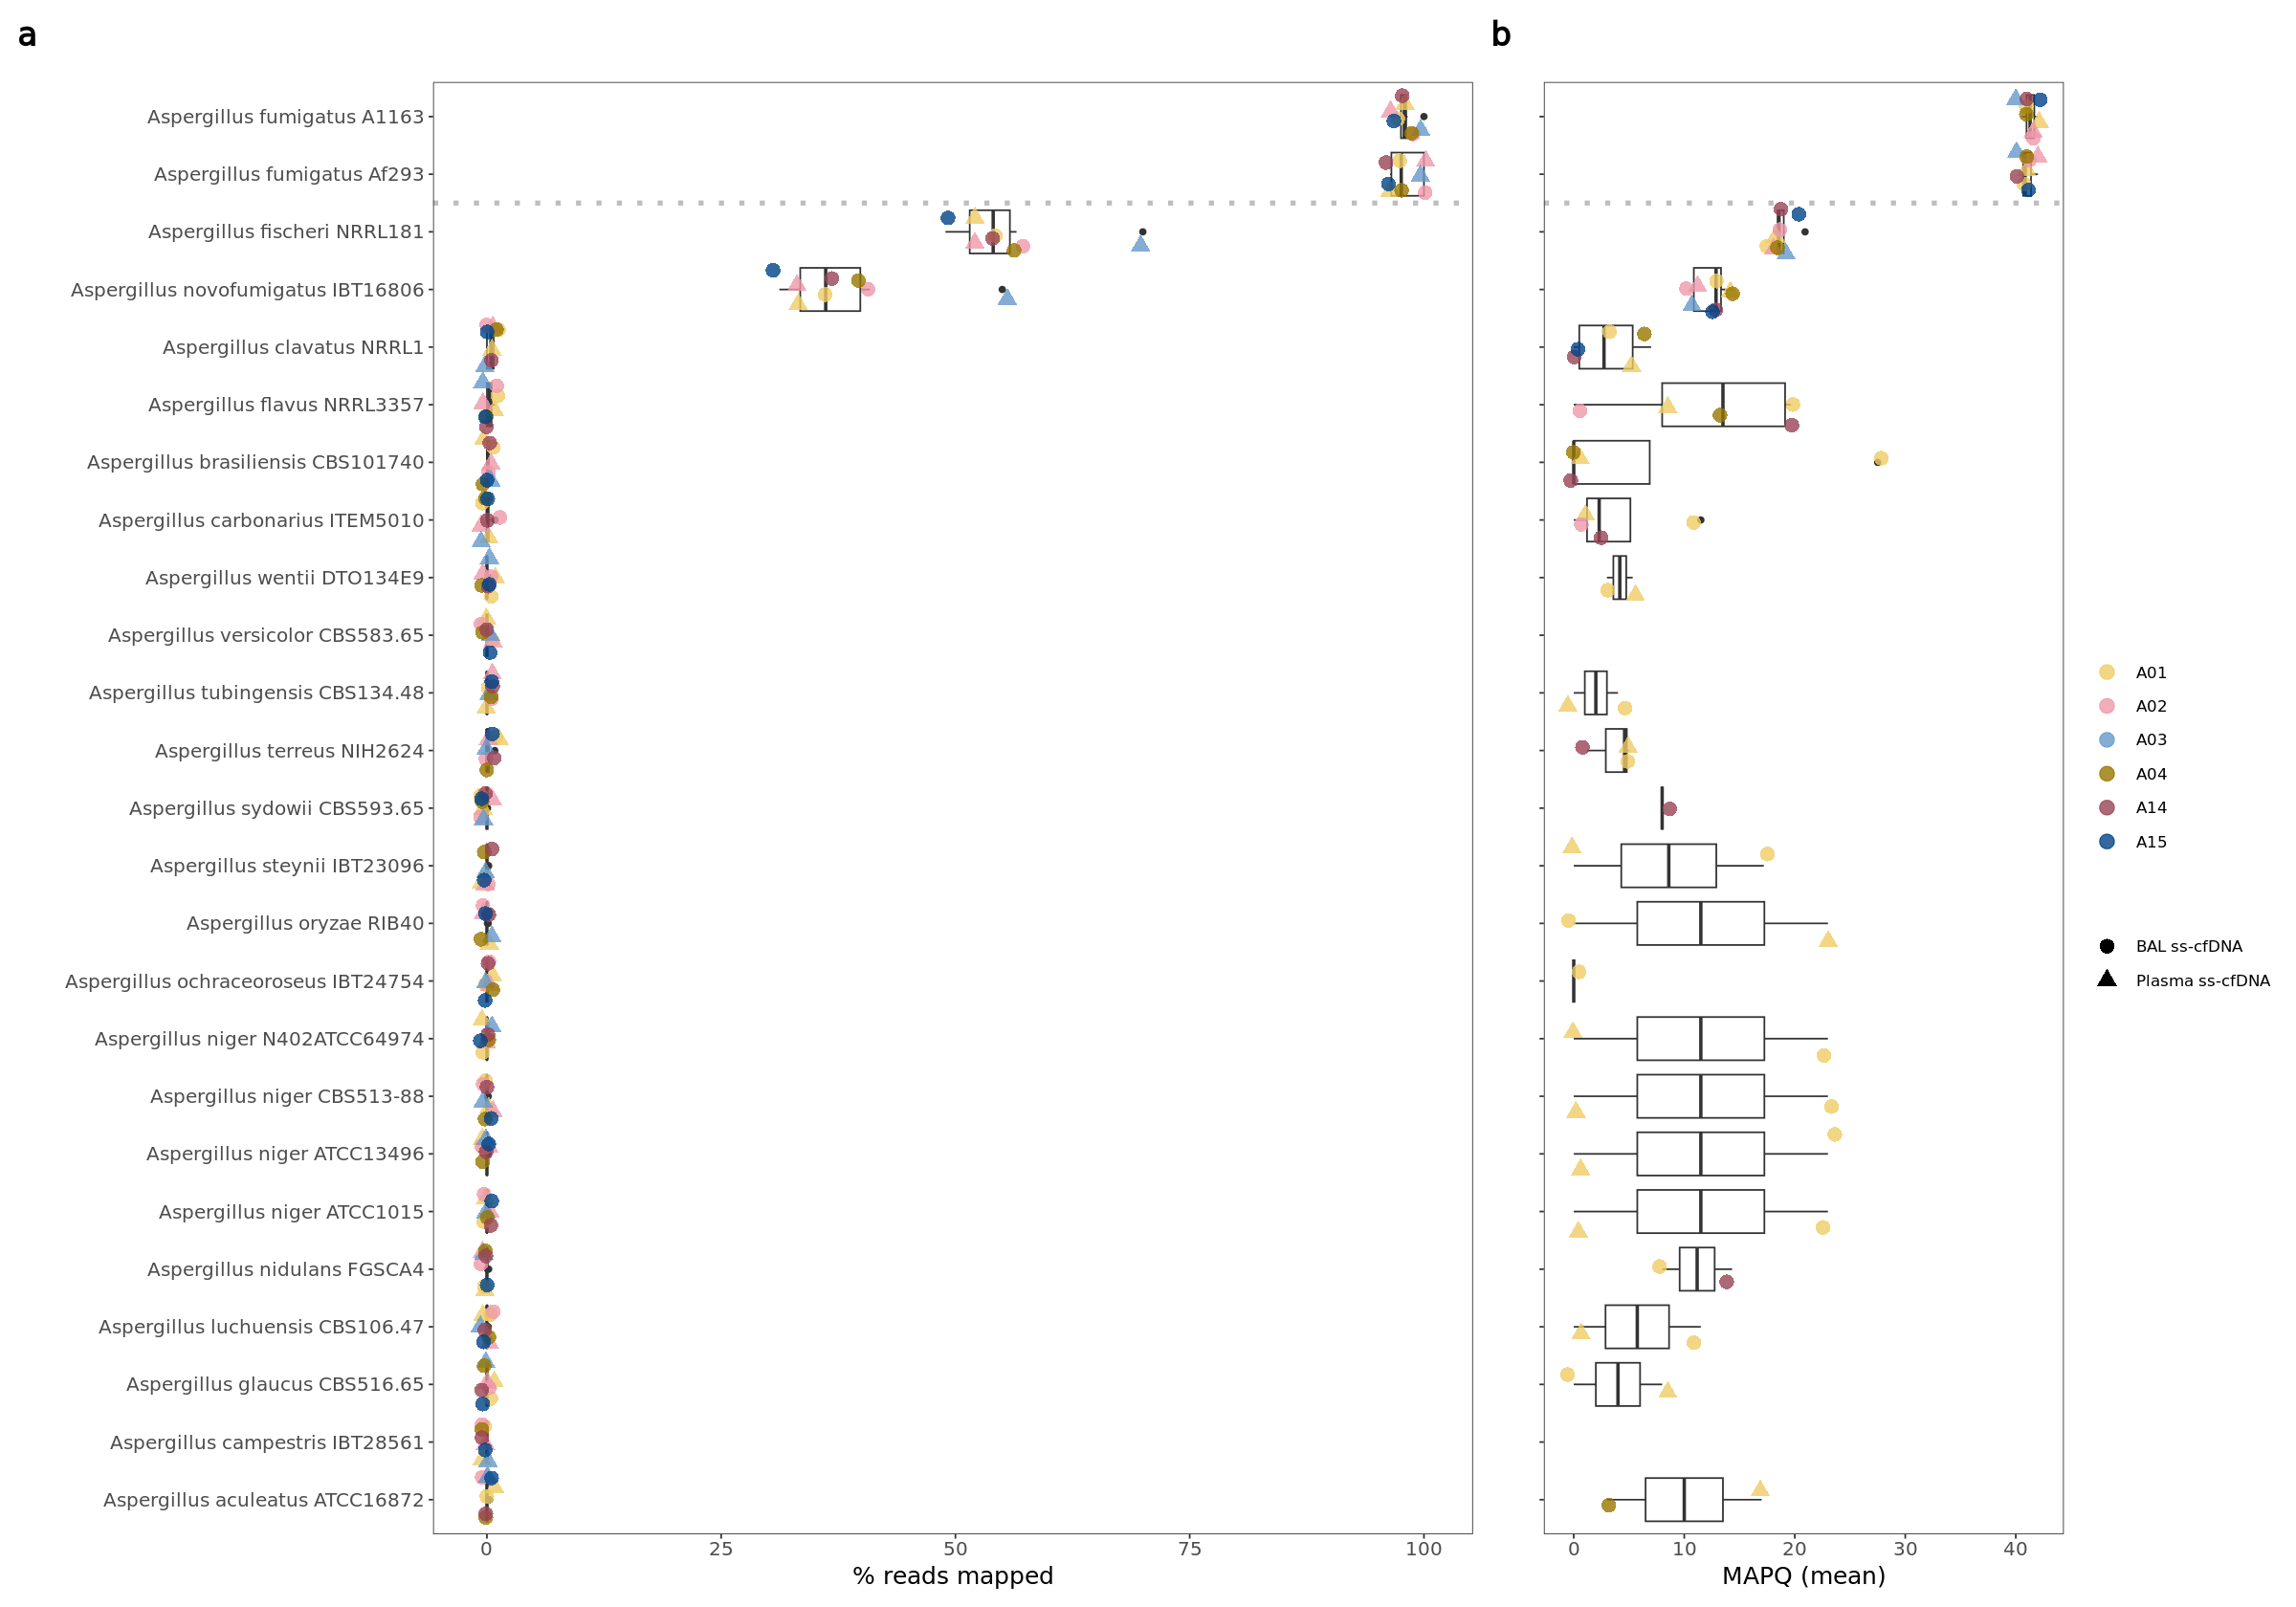

In [11]:
pos_samples <- c("A01Basp","A02Basp","A04Basp","A14Basp","A15Basp","A01Pasp","A02Pasp","A03Pasp")
data_all_Asp <- bam_all_Asp %>%   
    group_by(sample, db, CT, remap_genome, tax_name) %>% 
    summarise(n = n()/2, n_mapped = sum(!is.na(rname))/2, 
              prct_mapped = n_mapped/n*100, mean_mapq = mean(na.rm = TRUE, mapq), .groups = "keep") %>% 
    mutate(origin = ifelse(grepl(x = sample, pattern = "Basp"), yes = "BAL ss-cfDNA", no = 
                    ifelse(grepl(x = sample, pattern = "Pasp"), yes = "Plasma ss-cfDNA", no = "HELP"))) %>% 
    mutate(tax_name = gsub(tax_name, pattern = "(?<=[a-z])(?=[A-Z])", replacement = " ", perl = TRUE))  %>%
    mutate(sample_short = str_sub(sample, 1, 3)) %>% 
    filter(sample %in% pos_samples) %>% 
    mutate(sample = factor(sample, levels = pos_samples))

plot_prct_Asp <- data_all_Asp %>% 
    ggplot() +
        geom_boxplot(aes(x = prct_mapped, y = reorder(tax_name, prct_mapped, FUN = median))) +
        geom_jitter(aes(x = prct_mapped, y = reorder(tax_name, prct_mapped, FUN = median), 
                       col = sample_short, shape = origin), size = 4, width=0.7) + 
        geom_hline(yintercept = 23.5, linetype = "dotted", linewidth = 1.5, color = "grey") + 
        theme_bw() + 
        xlab("% reads mapped") + ylab("") + 
        ggtitle("") +
        scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
        labs(colour="", shape = "") #+ 
        #geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = 23.5), fill = "#F8F8F8", alpha = 0.01)

plot_meanMAPQ_Asp <- data_all_Asp %>% 
    ggplot() +
        geom_boxplot(aes(x = mean_mapq, y = reorder(tax_name, prct_mapped, FUN = median))) +
        geom_jitter(aes(x = mean_mapq, y = reorder(tax_name, prct_mapped, FUN = median), 
                       col = sample_short, shape = origin), size = 4, width=0.7) + 
        geom_hline(yintercept = 23.5, linetype = "dotted", linewidth = 1.5, color = "grey") + 
        theme_bw() + 
        xlab("MAPQ (mean)") + ylab("") + 
        
        scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
        labs(colour="", shape = "") + 
        #geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = 23.5), fill = "#F8F8F8", alpha = 0.01) + 
        theme(axis.text.y = element_blank()) + guides(col = FALSE, shape = FALSE) 

data_all_Asp %>% 
    group_by(db, CT, remap_genome, tax_name) %>% 
    summarise(median = round(median(prct_mapped), digits = 1), .groups = "keep") %>% 
    filter(median > 10)

options(repr.plot.width=20, repr.plot.height=14)
SuplFig14 <- 
    (plot_prct_Asp + labs(tag = "a")) + 
    (plot_meanMAPQ_Asp + labs(tag = "b")) + 
    plot_layout(guides = "collect", widths = c(2,1)) &
    theme(legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
        text = element_text(size = 15), legend.text = element_text(size = 10, colour = "black"),
        plot.title = element_text(size = 15, face = "bold"), 
        panel.grid = element_line(colour = "white", linewidth = 2),
        plot.tag = element_text(face = 'bold', size = 20)) 

SuplFig14

ggsave("../../output/suppl_figures/SuplFig14_R.png", 
       SuplFig14, width = 20, height = 14)
ggsave("../../output/suppl_figures/SuplFig14_R.pdf", 
       SuplFig14, width = 20, height = 14)